In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re
import itertools
from collections import Counter
import matplotlib.pyplot as plt
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/vacanciesru/vacancies_2018.csv
/kaggle/input/vacanciesru/vacancies_2003.csv
/kaggle/input/vacanciesru/vacancies_2008.csv
/kaggle/input/vacanciesru/vacancies_2006.csv
/kaggle/input/vacanciesru/vacancies_2013.csv
/kaggle/input/vacanciesru/vacancies_2009.csv
/kaggle/input/vacanciesru/vacancies_2017.csv
/kaggle/input/vacanciesru/vacancies_2020.csv
/kaggle/input/vacanciesru/vacancies_2005.csv
/kaggle/input/vacanciesru/vacancies_2012.csv
/kaggle/input/vacanciesru/vacancies_2019.csv
/kaggle/input/vacanciesru/vacancies_2011.csv
/kaggle/input/vacanciesru/vacancies_2007.csv
/kaggle/input/vacanciesru/vacancies_2014.csv
/kaggle/input/vacanciesru/vacancies_2015.csv
/kaggle/input/vacanciesru/vacancies_2016.csv
/kaggle/input/vacanciesru/vacancies_2010.csv
/kaggle/input/vacanciesru/vacancies_2004.csv


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold, KFold, GridSearchCV

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel, LsiModel, TfidfModel, Word2Vec, FastText, Doc2Vec

import re
import time
import string
import nltk
nltk.download('wordnet')
nltk.download('punkt')
from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords

from sklearn.decomposition import PCA, KernelPCA, IncrementalPCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import numpy as np
from collections import Counter
import itertools

from tqdm import tqdm

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
datasets = {}
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        file_reg = re.match(r"vacancies_[0-9]{4}.csv", filename)
        year_reg = re.search(r"[0-9]{4}", filename)
        if file_reg:
            datasets[int(year_reg.group())] = os.path.join(dirname, filename)
datasets

{2018: '/kaggle/input/vacanciesru/vacancies_2018.csv',
 2003: '/kaggle/input/vacanciesru/vacancies_2003.csv',
 2008: '/kaggle/input/vacanciesru/vacancies_2008.csv',
 2006: '/kaggle/input/vacanciesru/vacancies_2006.csv',
 2013: '/kaggle/input/vacanciesru/vacancies_2013.csv',
 2009: '/kaggle/input/vacanciesru/vacancies_2009.csv',
 2017: '/kaggle/input/vacanciesru/vacancies_2017.csv',
 2020: '/kaggle/input/vacanciesru/vacancies_2020.csv',
 2005: '/kaggle/input/vacanciesru/vacancies_2005.csv',
 2012: '/kaggle/input/vacanciesru/vacancies_2012.csv',
 2019: '/kaggle/input/vacanciesru/vacancies_2019.csv',
 2011: '/kaggle/input/vacanciesru/vacancies_2011.csv',
 2007: '/kaggle/input/vacanciesru/vacancies_2007.csv',
 2014: '/kaggle/input/vacanciesru/vacancies_2014.csv',
 2015: '/kaggle/input/vacanciesru/vacancies_2015.csv',
 2016: '/kaggle/input/vacanciesru/vacancies_2016.csv',
 2010: '/kaggle/input/vacanciesru/vacancies_2010.csv',
 2004: '/kaggle/input/vacanciesru/vacancies_2004.csv'}

In [4]:
#Вспомогательные функции
def count_freq_by_year(df, year, column):
    """Функция считывает набор данных за указанный год и 
    возвращает количество вакансий за этот год по каждой профессии
    :param df: набор данных за указанный год
    :param year: год, за который осуществляется анализ
    :return: список профессий с их частотами за данный год в формате pandas data frame"""
    
    key_skills = df[column].fillna('').apply(lambda row: row.split("\n")).values
    skills_list = itertools.chain.from_iterable(key_skills)
    skills_list = filter(lambda val: val != "", skills_list)
    count_skills = Counter(skills_list)
    sort_count_skills = sorted(count_skills.items(), key=lambda item: item[1], reverse=True)
    skill_with_freq = pd.DataFrame(sort_count_skills, columns=['Навык', year])
    skill_with_freq = skill_with_freq.set_index('Навык')
    return skill_with_freq


def visualization_stat(df, N_from=0, N_to=10):
    """Функция трансформирует набор данных
    и строит графики по переданной статистике
    :return: строит график"""
    # N_from - с какой позиции будет начинаться отсчёт для графиков
    # N_to - до какой позиции будут строиться графики
    
    """Выберем N наиболее часто встречаемых профессий и построим график"""
    df = df.sort_values(df.columns[-1], ascending=False)
    for_plot = df[N_from:N_to].transpose()
    for_plot.plot(figsize=(15,10))
    plt.legend(loc='right')
    

#Функция для графиков с изменением процента вакансий
def percent1(column, value, title1):
    period = 2003, 2021
    use_cols = [column]
    df = pd.DataFrame(columns=['year', 'percent'])
    for year in range(*period):
        year_df = pd.read_csv(datasets[year], usecols=use_cols).dropna()
        count = year_df.count()
        year_df = year_df[year_df[column] == value]
        result = len(year_df)*100/count
        df.loc[len(df)] = [year, int(result)]
        del year_df
    df.plot(x='year', y='percent', kind='bar', title=title1)
    del df

## Обзор данных

In [5]:
# Загружаем данные
df = pd.read_csv(datasets[2020])
pd.set_option('display.max_columns', None)
print(df.shape)
# Очищаем от ненужных нам столбцов
col_to_delete = ['id', 'allow_messages', 'billing_type_id', 'billing_type_name', 
                 'experience_name', 'driver_license_types', 'response_letter_required', 
                 'type_id', 'type_name', 'schedule_name', 'archived', 'response_url', 
                 'test_required', 'alternate_url', 'apply_alternate_url', 
                 'insider_interview', 'code', 'specializations', 'employer_id', 'employer_vacancies_url',
                 'employer_alternate_url', 'address_street', 'address_building','address_description',
                 'area_id', 'department_id', 'department_name', 'premium', 'contacts', 'has_test']
df.drop(columns=col_to_delete, inplace=True)
# Очищаем от неразмеченных зарплат. В данном случае можно отбросить много данных.
# Данных для анализа хватает в любом случае. 
df = df.iloc[df[['salary_from', 'salary_to', 'salary_gross', 'salary_currency']].dropna().index]
# Была идея фильтровать не полностью, а по наличию одной из зарплат, но тогда строк больше всего на 9 тысяч
#df = df[df['salary_from'].isna() | df['salary_to'].isna()]
print(df.shape)
df.head()

(587637, 56)
(137690, 26)


,description,key_skills,schedule_id,accept_handicapped,accept_kids,experience_id,accept_incomplete_resumes,employer_name,employer_trusted,employer_industries,salary_from,salary_to,salary_gross,salary_currency,name,area_name,area_url,created_at,published_at,address_city,address_lat,address_lng,employment_id,employment_name,prof_classes_found,terms_found
3,<p><strong>В твоих руках - отличная возможност...,NaN,fullDay,False,False,noExperience,False,МегаФон Ритейл,True,Розничная сеть (мобильный ретейл),23000.0,29000.0,False,RUR,Продавец - Консультант офиса продаж и обслужив...,Копейск,https://api.hh.ru/areas/1395,2020-01-13T12:38:10+0300,2020-01-13T12:38:10+0300,Челябинск,55.164515,61.401188,full,Полная занятость,prodajnik,медицинская_страховка официальное_трудоустройс...
15,<strong>Обязанности:</strong> <ul> <li>Активны...,Активные продажи\nХолодные продажи\nПрямые про...,fullDay,False,False,noExperience,False,Ростелеком,True,Интернет-провайдер\nОптоволоконная связь\nФикс...,14000.0,50000.0,True,RUR,Агент по сбору заявок на подключение,Кострома,https://api.hh.ru/areas/52,2020-02-03T09:05:56+0300,2020-02-03T09:05:56+0300,NaN,NaN,NaN,full,Полная занятость,NaN,дружный_коллектив опыт_работы
25,<p><strong><em>В нашу команду требуются активн...,B2B Продажи\nВедение переговоров,fullDay,False,False,noExperience,True,Север Телеком,True,Оптоволоконная связь\nФиксированная связь,35000.0,60000.0,False,RUR,Менеджер по работе с корпоративными клиентами,Череповец,https://api.hh.ru/areas/1753,2020-01-15T10:44:35+0300,2020-01-15T10:44:35+0300,Череповец,59.122511,37.930177,full,Полная занятость,support,комфортный_офис power_point менеджер_по_продаж...
69,<strong>Обязанности:</strong> <ul> <li>Настрой...,Windows 7\nВысокая скорость печати\nWindows Os...,fullDay,False,False,between3And6,False,Филиал ФГБУ ИАЦ Судебного департамента в Томск...,True,NaN,30000.0,35000.0,False,RUR,Инженер-программист,Томск,https://api.hh.ru/areas/90,2020-04-10T12:40:35+0300,2020-04-10T12:40:35+0300,NaN,NaN,NaN,full,Полная занятость,programmer,высшее_образование windows_7 windows_2003 тест...
74,<p>Привет! Наша команда VL.ru в Томске в поиск...,Atlassian Jira\nSQL\nБазы данных\nРазработка т...,fullDay,False,False,between1And3,False,VL.RU,True,"Системная интеграция, автоматизации технологи...",45000.0,73000.0,True,RUR,Системный аналитик,Томск,https://api.hh.ru/areas/90,2020-04-10T12:40:57+0300,2020-04-10T12:40:57+0300,Томск,56.479501,84.977572,full,Полная занятость,analyst,высшее_образование site разработчик google_ana...


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 137690 entries, 3 to 587624
Data columns (total 26 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   description                137690 non-null  object 
 1   key_skills                 105287 non-null  object 
 2   schedule_id                137690 non-null  object 
 3   accept_handicapped         137690 non-null  bool   
 4   accept_kids                137690 non-null  bool   
 5   experience_id              137690 non-null  object 
 6   accept_incomplete_resumes  137690 non-null  bool   
 7   employer_name              137690 non-null  object 
 8   employer_trusted           137469 non-null  object 
 9   employer_industries        98839 non-null   object 
 10  salary_from                137690 non-null  float64
 11  salary_to                  137690 non-null  float64
 12  salary_gross               137690 non-null  object 
 13  salary_currency            13

## Значений в таблице много. Из интересующего:

Описание (отчистить от тегов (можно с помощью уже готовой функции), рассмотреть)

Ключевые скиллы, расписание дня,

Работодатели ('employer_name', 'employer_trusted', 'employer_industries')

Территория вакансии ('area_name', 'area_url', 'created_at', 'published_at', 'address_city', 'address_lat', 'address_lng')

Зарплата ('salary_from', 'salary_to', 'salary_gross', 'salary_currency')

'description'

'key_skills' (отчистить от тегов и посмотреть частоту слов)

'schedule_id' (OHE), распорядок рабочего дня

'accept_handicapped' булева переменная (инвалиды)
 
'accept_kids' булева переменная
 
'experience_id' (разбить на две переменные: опыт ОТ и опыт ДО)

'contacts' (заменить на булеву переменную)

'accept_incomplete_resumes' (проверить на грейд)
 
'has_test' (на грейд)

'name' (попробовать вытащить направления вакансий)

'employment_id' (OHE)

'prof_classes_found' (вытащить направления вакансий)
       
Удалить: 'id', 'allow_messages', 'billing_type_id', 'billing_type_name', 'experience_name', 'driver_license_types', 'response_letter_required', 'type_id', 'type_name', 'schedule_name', 'archived', 'response_url', 'test_required', 'alternate_url', 'apply_alternate_url', 'insider_interview', 'code', 'specializations', 'employer_id', 'employer_vacancies_url', 'employer_alternate_url', 'address_street', 'address_building','address_description', 'area_id', 'department_id', 'department_name', 'premium', 'contacts', 'has_test'

In [7]:
# Делать анализ я буду потом.
# Из идей: рассмотреть изменения необходимых скиллов через года
# Рассмотреть динамику работодателей (кто больше/меньше нанимает программистов)
# Тип рабочего дня сквозь года и с разными типами организаций
# Наличие опыта
# Специализации

# Также попробовать обобщить данные с помощью t-SNE (методом локтя подобрать количество измерений)

## Обзор и сравнение количества вакансий по скиллам

CPU times: user 2min 45s, sys: 12.7 s, total: 2min 58s
Wall time: 5min 9s


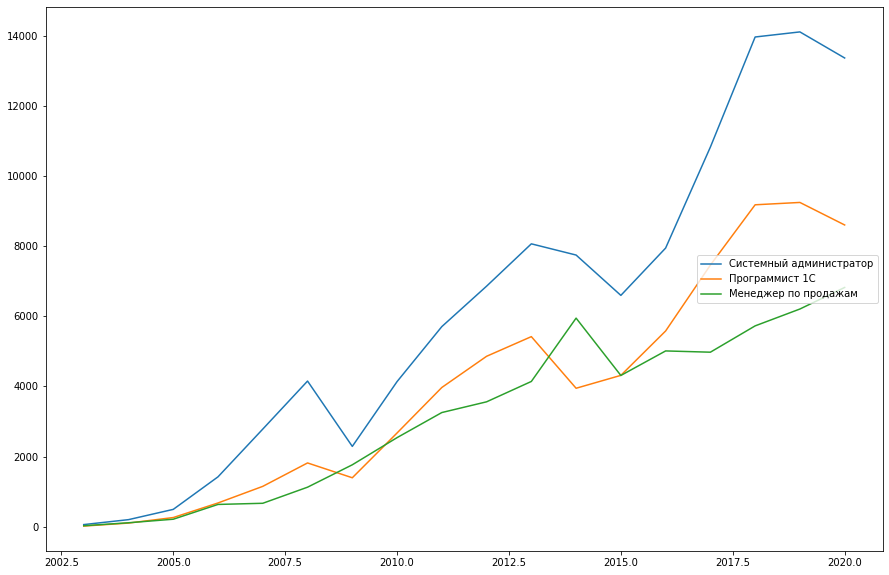

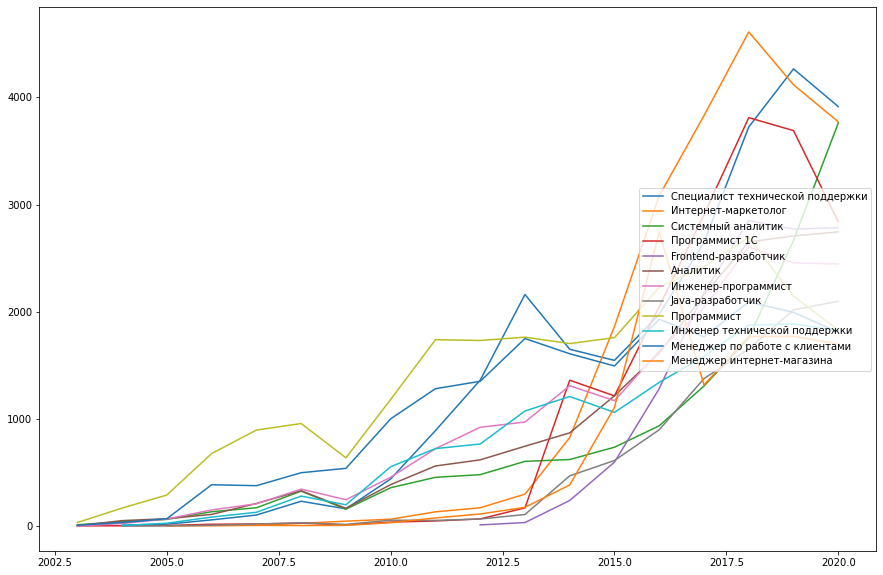

In [8]:
%%time
period = 2003, 2021
use_cols = ['name']
df = pd.DataFrame()
for year in range(*period):
    df = pd.concat([df, count_freq_by_year(pd.read_csv(datasets[year], usecols=use_cols), year, 'name')], axis=1)

# Идите в сисадмины и девопс, ребята
visualization_stat(df, N_to=3)
visualization_stat(df, N_from=3, N_to=15)

CPU times: user 2min 44s, sys: 14.7 s, total: 2min 59s
Wall time: 5min 8s


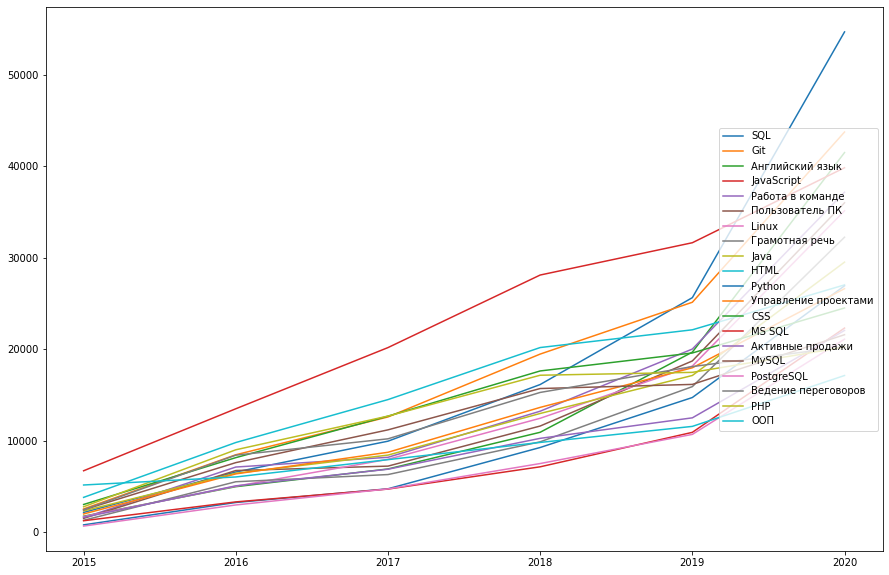

In [9]:
%%time
period = 2003, 2021
use_cols = ['key_skills']
df = pd.DataFrame()
for year in range(*period):
    df = pd.concat([df, count_freq_by_year(pd.read_csv(datasets[year], usecols=use_cols), year, 'key_skills')], axis=1)

# Из графика можно сделать вывод, что Soft skills и инструменты, напрямую не относящиеся к программированию,
# становятся важнее, чем знание каких-то ЯП/теории (ООП вообще на 20 месте, а система контроля версий на 2 месте).
# Причём их рост сильно заметен за последние 3 года
visualization_stat(df, N_to=20)

CPU times: user 2min 40s, sys: 14.4 s, total: 2min 54s
Wall time: 5min 7s


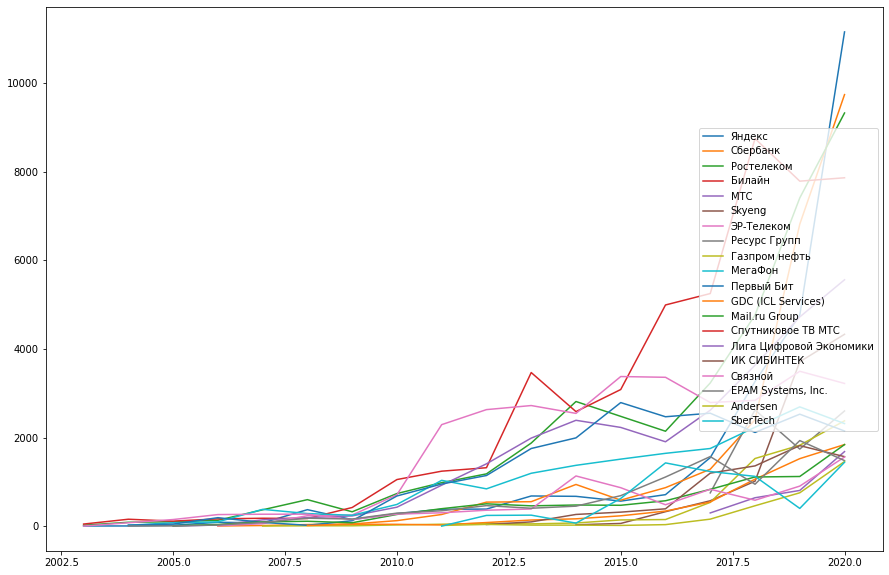

In [10]:
%%time
period = 2003, 2021
use_cols = ['employer_name']
df = pd.DataFrame()
for year in range(*period):
    df = pd.concat([df, count_freq_by_year(pd.read_csv(datasets[year], usecols=use_cols), year, 'employer_name')], axis=1)

# График динамики самых популярных работодателей
# Из странного для меня: 
# Skyeng на очень высокой позиции
# Я не слышал про ЭР-Телеком, а он много где есть
# Отдельная организация у МТС по спутниковому ТВ
# Несколько компаний, работающих на аутсорс
visualization_stat(df, N_to=20)

CPU times: user 2min 40s, sys: 14.3 s, total: 2min 54s
Wall time: 5min


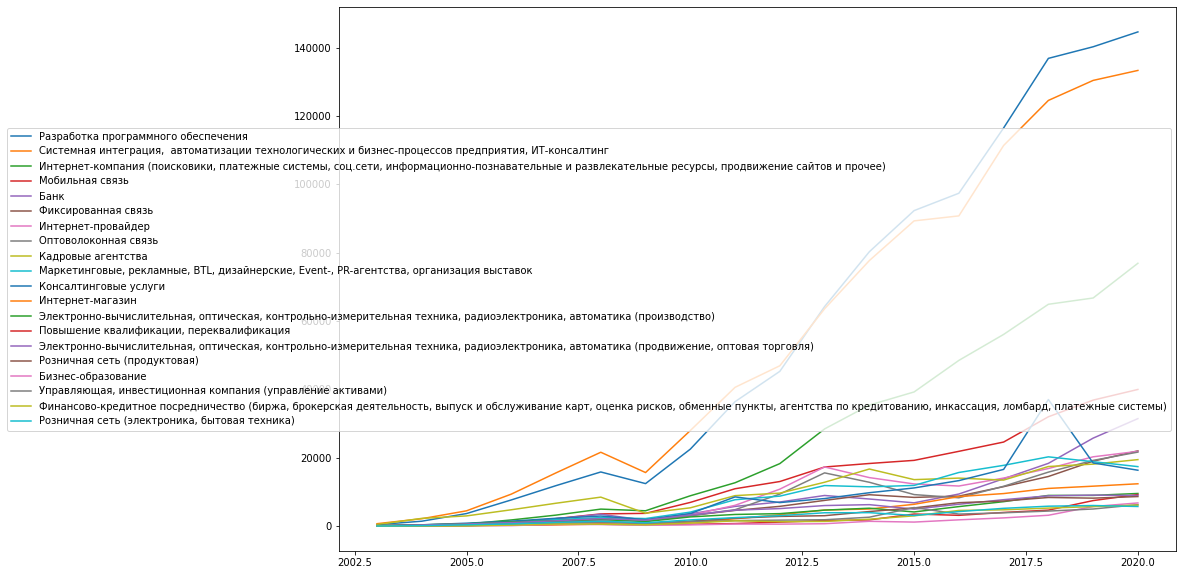

In [11]:
%%time
period = 2003, 2021
use_cols = ['employer_industries']
df = pd.DataFrame()
for year in range(*period):
    df = pd.concat([df, count_freq_by_year(pd.read_csv(datasets[year], usecols=use_cols), year, 'employer_industries')], axis=1)

# График динамики направлений компаний, которые нанимают
visualization_stat(df, N_to=20)

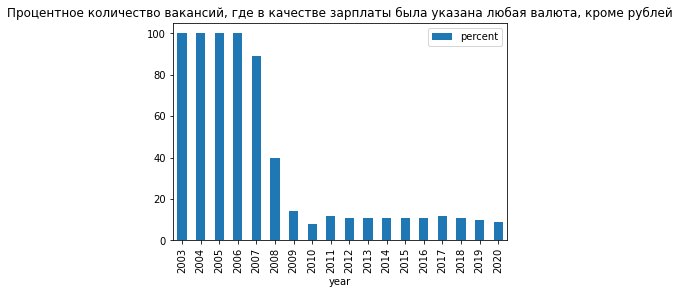

In [12]:
# Интересно посмотреть процентное количество вакансий, где в качестве зарплаты была указана любая валюта, кроме рублей
# Интересно, что до 2007 года все зарплаты были в другой валюте. После 2010 количество валютных зарплат стало колебаться в районе 10-15%
period = 2003, 2021
use_cols = ['salary_currency']
df = pd.DataFrame(columns=['year', 'percent'])
for year in range(*period):
    year_df = pd.read_csv(datasets[year], usecols=use_cols).dropna()
    count = year_df.count()
    year_df = year_df[year_df['salary_currency'] != 'RUR']
    result = len(year_df)*100/count
    df.loc[len(df)] = [year, int(result)]
    del year_df
df.plot(x='year', y='percent', kind='bar', 
        title='Процентное количество вакансий, где в качестве зарплаты была указана любая валюта, кроме рублей')
del df

CPU times: user 2min 26s, sys: 14.4 s, total: 2min 41s
Wall time: 4min 46s


<AxesSubplot:xlabel='year'>

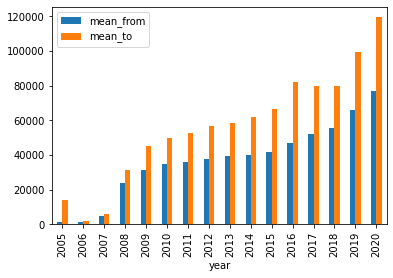

In [13]:
%%time
# Изменение средней зарплатной вилки
period = 2005, 2021
use_cols = ['salary_from', 'salary_to']
df = pd.DataFrame(columns=['year', 'mean_from', 'mean_to'])
for year in range(*period):
    year_df = pd.read_csv(datasets[year], usecols=use_cols)
    mean = year_df.mean()
    df.loc[len(df)] = [year, int(mean['salary_from'],), int(mean['salary_to'])]
    del year_df, mean
df.plot(x='year', y=['mean_from', 'mean_to'], kind='bar')

100%|██████████| 18/18 [04:59<00:00, 16.62s/it]

CPU times: user 2min 30s, sys: 14.6 s, total: 2min 45s
Wall time: 4min 59s


<AxesSubplot:xlabel='year'>

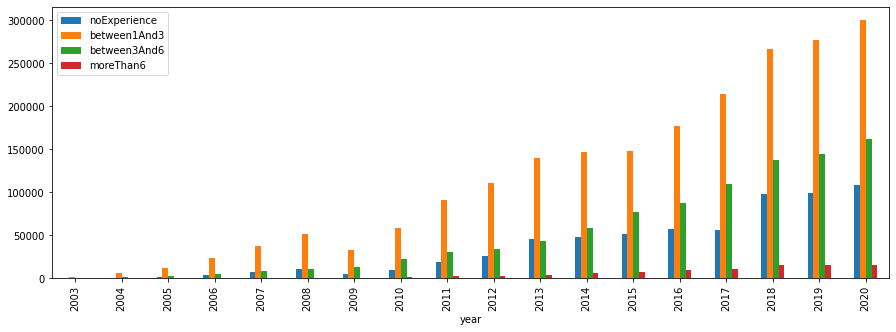

In [14]:
%%time
# Изменение количества вакансий по количеству опыта
# Растёт количество вакансий начального уровня и для людей с хорошим опытом
# но основой всё равно являются работники с опытом от 1 до 3 лет
# Количество вакансий в 2009 и 2015 году упало (по понятным причинам)
# также там заметно более сильное падение количества начальных вакансий
period = 2003, 2021
use_cols = ['experience_id']
df = pd.DataFrame(columns=['year', 'noExperience', 'between1And3', 'between3And6', 'moreThan6'])
for year in tqdm(range(*period)):
    year_df = pd.read_csv(datasets[year], usecols=use_cols).groupby(by=['experience_id'])['experience_id'].count()
    df.loc[len(df)] = [year, year_df['noExperience'], year_df['between1And3'], year_df['between3And6'], year_df['moreThan6']]
    del year_df
df.plot(x='year', y=['noExperience', 'between1And3', 'between3And6', 'moreThan6'], kind='bar', figsize=(15,5))

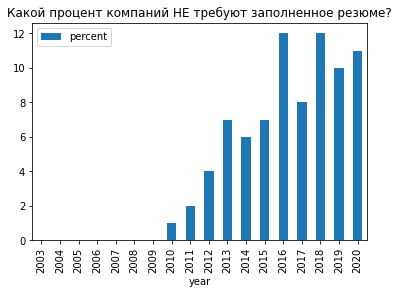

In [15]:
# В последние 10 лет компании начали делать послабления: теперь 10% вакансий не требуют резюме
# (скорее всего это вакансии начального уровня)
percent1('accept_incomplete_resumes', True, 'Какой процент компаний НЕ требуют заполненное резюме?')